# Progetto Big Data - Unipa

## Import

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn import metrics
import matplotlib.pyplot as plt

## Data Load

In [5]:
df = pd.read_csv("../data/creditcard.csv")

y_class = df["Class"]

df = df.drop(columns= ["Class"])

## Creazione dei dataset train e test

Per prima cosa, assegniamo alla variabile `X` i valori corrispondenti alla matrice delle feature, assegniamo alla variabile `y` il vettore delle classi da predire.

In [6]:
X = df.values
y = y_class.values

Dato che i valori di `y` non sono bilanciati, uno split semplice del dataset creerebbe due sottodataset con frequenze di valori diverse: 

In [7]:
np.random.seed(42)
y_rand = np.copy(y)
np.random.shuffle(y_rand)

y_rand_subset1 = y_rand[:1000]
y_rand_subset2 = y_rand[1000:]

print(pd.Series(y_rand_subset1).value_counts(normalize=1))
print(pd.Series(y_rand_subset2).value_counts(normalize=1))

0    0.998
1    0.002
dtype: float64
0    0.998273
1    0.001727
dtype: float64


Data questa dinamica, utilizziamo lo `StratifiedShuffleSplit` di scikit-learn che permette di ottenere dei subset mantenendo equilibrata la classe obiettivo.

In [8]:
sss0 = StratifiedShuffleSplit(n_splits=1, test_size=.1, random_state=42)
train_index, test_index = next(iter(sss0.split(X, y)))
X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((256326, 30), (28481, 30), (256326,), (28481,))

In [9]:
print(pd.Series(y_test).value_counts(normalize=1))
print(pd.Series(y_train).value_counts(normalize=1))

0    0.99828
1    0.00172
dtype: float64
0    0.998272
1    0.001728
dtype: float64


## PreProcessing e creazione pipeline Classificazione

1. Utilizzeremo `StandardScaler` per standardizzare le feature in modo da ottenere valori che abbiano media 0 e varianza 1. 
2. Utilizzeremo `SelectFromModel` per selezionare le feature maggiormente determinanti per la classificazione.
3. Utilizzeremo `RandomForestClassifier` come classificatore per predire il valore di `y`.

`SelectFromModel` utilizza un classificatore e analizza come il classificatore attribuisce peso alle features ai fini della classificazione finale, una volta individuate le feature maggiormente rilevanti modifica la matrice originaria eliminando le colonne corrispondenti.

In [10]:
classifier = Pipeline([
    ("scat_standard_scaling", StandardScaler()),
    ("feature_selection", SelectFromModel(ExtraTreesClassifier(n_estimators=50, n_jobs=-1, random_state=42, class_weight="balanced", verbose=1))),
    ("classifier", RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42, class_weight="balanced", verbose=1))
], verbose=1)

classifier

Pipeline(steps=[('scat_standard_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(class_weight='balanced',
                                                                n_estimators=50,
                                                                n_jobs=-1,
                                                                random_state=42,
                                                                verbose=1))),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=10, n_jobs=-1,
                                        random_state=42, verbose=1))],
         verbose=1)

## Esecuzione Test

Eseguiremo il fit della pipeline con dei parametri arbitrari per osservare il comportamento dei vari componenti. 

In [11]:
classifier.fit(X_train, y_train)

[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   0.2s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[Pipeline] . (step 2 of 3) Processing feature_selection, total=   4.8s


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.9s


[Pipeline] ........ (step 3 of 3) Processing classifier, total=   2.0s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


Pipeline(steps=[('scat_standard_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(class_weight='balanced',
                                                                n_estimators=50,
                                                                n_jobs=-1,
                                                                random_state=42,
                                                                verbose=1))),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=10, n_jobs=-1,
                                        random_state=42, verbose=1))],
         verbose=1)

A seguito del training, è possibile osservare come i differenti step di preprocessing abbiano eseguito lo scaling e la selezione delle features.

Scaler:

In [12]:
scaler = classifier.steps[0][1]

print(scaler)
print(np.mean(X_train, axis=0) == scaler.mean_)
print(np.var(X_train, axis=0) == scaler.var_)

X_train_scaled = scaler.transform(X_train)
print(np.round(np.mean(X_train_scaled, axis=0), 4))
print(np.var(X_train_scaled, axis=0))

StandardScaler()
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[-0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0. -0. -0. -0.  0.  0.  0.
 -0. -0. -0.  0. -0. -0. -0.  0.  0. -0.  0.  0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


Feature Selector:

In [13]:
selector = classifier.steps[1][1]

print(selector)

feature_names = df.columns
selected_feature_names = feature_names[selector.get_support()]

print("Features selezionate da SelectFromModel: "
      f"{selected_feature_names}")

SelectFromModel(estimator=ExtraTreesClassifier(class_weight='balanced',
                                               n_estimators=50, n_jobs=-1,
                                               random_state=42, verbose=1))
Features selezionate da SelectFromModel: Index(['V3', 'V4', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'], dtype='object')


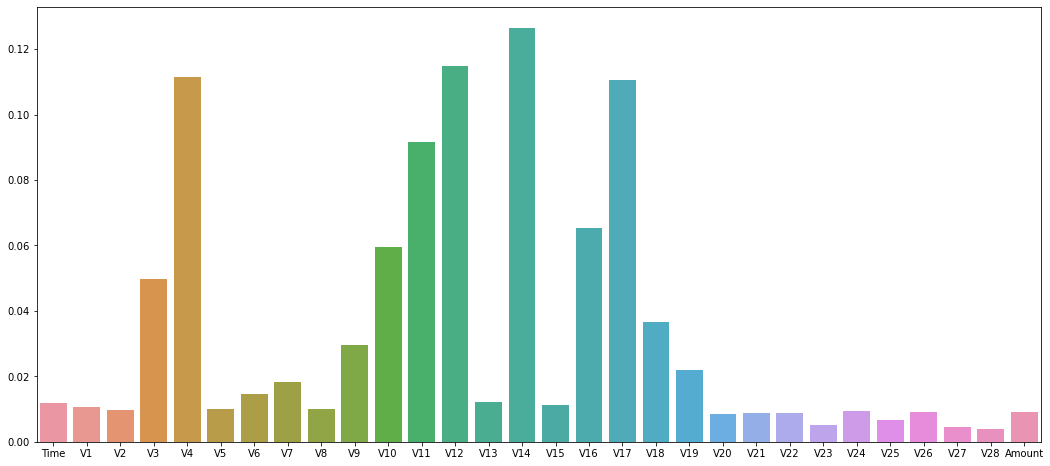

In [14]:
tree = selector.estimator_

feature_importances = tree.feature_importances_

fig, ax = plt.subplots(1, 1, figsize =(18,8))

g = sns.barplot(x = feature_names.values, y = feature_importances, ax = ax)


Example Predictions:

In [15]:
Y = classifier.predict(X_train)
Y.shape

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


(256326,)

## Valutazione del Modello

Costruzione score:

In [16]:
def score_auc(Y, y_train):
    # Calcoliamo i valori di p, i valori recall (r) ed il threshold della curva precision recall
    # attraverso l'apposita funzione di scikit-learn
    p, r, tresholds = metrics.precision_recall_curve(
        Y,
        y_train,
    )
    # Utilizziamo i valori per calcolare l'area under the curve (AUC)
    metric = metrics.auc(p, r)
    return 1 - metric

score_auc(Y, y_train)

0.027659924244157086

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


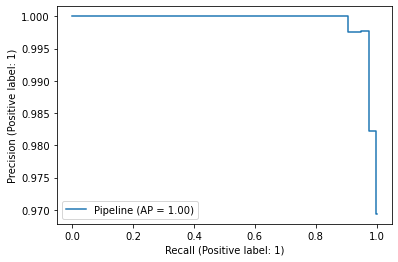

In [17]:
disp = plot_precision_recall_curve(classifier , X_train, y_train)

Per un ulteriore livello di dettaglio, si riportano i valori di precision e recall f1_score per il modello di classificazione

In [35]:
print(metrics.classification_report(y_true=y_train, y_pred=Y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    255883
           1       1.00      0.95      0.97       443

    accuracy                           1.00    256326
   macro avg       1.00      0.98      0.99    256326
weighted avg       1.00      1.00      1.00    256326



Dato il forte sbilanciamento delle classi è necessario ponderare le stesse al fine di ottenere un f1_score che tenga questo effetto in conto

In [36]:
sample_weight = pd.Series(y_train).value_counts(normalize=True).apply(lambda x:1-x).reindex(y_train)

print(metrics.classification_report(y_true=y_train, y_pred=Y, sample_weight=sample_weight))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98 442.23437731820246
           1       1.00      0.95      0.97 442.234377316383

    accuracy                           0.98 884.4687546345855
   macro avg       0.98      0.98      0.98 884.4687546345855
weighted avg       0.98      0.98      0.98 884.4687546345855



## Ottimizzazione dei parametri della pipeline

In questa prima esecuzione i parametri del classificatore utilizzati nella pipeline sono stati forniti in maniera arbitraria. Al fine di recuperare la migliore configurazione possibile per il classificatore, è possibile utilizzare una modalità di auto-ML attraverso una ricerca iterativa incrociata dei parametri ottimali per il modello.

Come obiettivo dell'ottimizzatore è stata fornita una funzione che cerca di massimizzare l'AUC (Nel nostro caso, la funzione `score_auc` restituisce il valore `1-auc`, da minimizzare).

In [37]:
model_scorer = metrics.make_scorer(score_func=score_auc)
# Cross-validation score

In [38]:
param_grid = {
    "classifier__n_estimators": [5, 10, 20],
}
search = GridSearchCV(classifier, param_grid=param_grid, n_jobs=-1, verbose=1, scoring=model_scorer)
search.fit(X_train, y_train)

print(search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   0.2s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[Pipeline] . (step 2 of 3) Processing feature_selection, total=   6.3s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   1.4s
0.15284856932711466
{'classifier__n_estimators': 5}


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


## Test del classificatore

In [40]:
Y_test = classifier.predict(X_test)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


In [41]:
score_auc(Y_test, y_test)

0.168558272647214

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


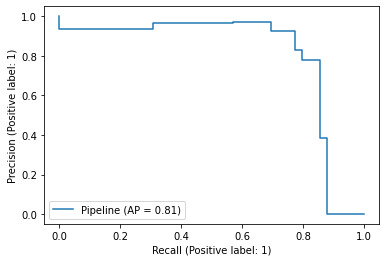

In [42]:
disp_test = plot_precision_recall_curve(classifier , X_test, y_test)

Per un ulteriore livello di dettaglio, si riportano i valori di precision e recall f1_score per il modello di classificazione

Dato il forte sbilanciamento delle classi è necessario ponderare le stesse al fine di ottenere un f1_score che tenga questo effetto in conto

In [44]:
sample_weight = pd.Series(y_test).value_counts(normalize=True).apply(lambda x:1-x).reindex(y_test)

print(metrics.classification_report(y_true=y_test, y_pred=Y_test, sample_weight=sample_weight))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87 48.915698184776204
           1       1.00      0.69      0.82 48.91569818475472

    accuracy                           0.85 97.83139636953092
   macro avg       0.88      0.85      0.84 97.83139636953092
weighted avg       0.88      0.85      0.84 97.83139636953092



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished


[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   1.3s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=  39.3s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   9.4s
[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   1.5s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=  38.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   4.9s
[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   0.7s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=  32.5s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=  12.4s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.8s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 

[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   1.3s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=  38.7s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   5.3s
[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   0.6s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=  34.6s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=  13.8s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 

[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   0.5s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=  38.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   7.5s
[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   1.0s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=  33.2s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=  16.9s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.8s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 

[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   1.4s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=  39.5s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   5.3s
[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   1.1s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=  34.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=  16.6s
[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   1.5s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=  39.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   5.1s
[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   0.6s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=  34.3s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=  17.5s
[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   0.4s
[Pipeline] . (step 2 of 3) Processing feature_selection, total

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.6s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 

[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   1.5s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=  38.7s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   7.6s
[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   2.0s
[Pipeline] . (step 2 of 3) Processing feature_selection, total=  34.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=  14.0s


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.8s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 